## Import required libraries

In [63]:
import os
from osgeo import gdal, osr
import numpy as np
from random import randint
from scipy import ndimage
from copy import copy
from matplotlib import pyplot as plt
%matplotlib inline

## Configuration parameters: Enter own values

Specify a unique name for the project as `save_folder`. A folder with your chosen name will be created in the results folder, and all outputs for the design will be saved there. E.g:

In [64]:
save_folder = 'Stratified_Design_Demo'

Enter path to invalid areas mask (`mask_path`). This should be in GeoTiff format and saved in the 'raw' data folder. E.g:

In [65]:
mask_path = 'raw/InvalidAreasMask.tif'

Enter an integer number of sample sites (`nsp`). E.g

In [66]:
nsp = 30

## Load data

In [67]:
def get_file_info(file_path):
    file_raw = gdal.Open(file_path)
    prj = file_raw.GetProjection(); srs = osr.SpatialReference(wkt=prj)
    auth_code = srs.GetAuthorityCode(None)
    GeoT = file_raw.GetGeoTransform(); res = GeoT[1]
    file_map = file_raw.ReadAsArray()
    nbins = len(np.unique(file_map))
    return file_map, nbins, res, GeoT, auth_code

In [68]:
print('Loading {} ...'.format(mask_path))

mask, nbins, res, GeoT, auth_code = get_file_info(mask_path)

print('\nNumber of categories in mask (should only be two): {}'.format(nbins))
print('Pixel resolution (m): {}'.format(res))
print('GeoT info: {}'.format(GeoT))
print('Authority code: {}'.format(auth_code))

Loading raw/InvalidAreasMask.tif ...

Number of categories in mask (should only be two): 2
Pixel resolution (m): 30.0
GeoT info: (604343.5084861958, 30.0, 0.0, 5302852.190465175, 0.0, -30.0)
Authority code: 32759


**Plot mask**: Check that invalid areas are coded as 0, and 1 for valid areas

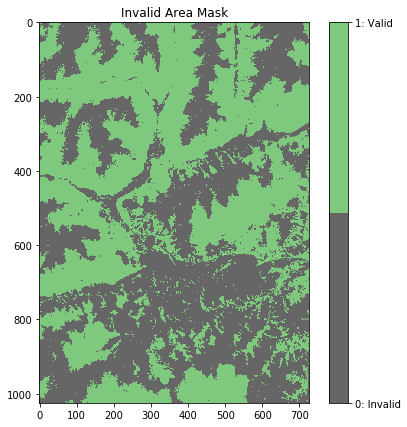

In [99]:
plt.figure(figsize=(7, 7))
plt.imshow(mask, cmap=plt.cm.get_cmap('Accent_r', 2))
plt.title('Invalid Area Mask')
cbar = plt.colorbar()
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0: Invalid', '1: Valid'])
plt.show()

## Generate stratified design

In [35]:
def generate_stratified_design(mask, nsp):
    
    # Initialise empty arrays and lists to save design
    imheight, imwidth = mask.shape
    dist_im = np.ones((imheight, imwidth))
    sites = np.ones((imheight, imwidth))
    mask_aux = copy(mask)
    x_vals = []
    y_vals = []

    for i in range(nsp):
        
        print('Plotting site {}'.format(i+1))

        # Make all elements of EDT map in invalid region 0
        dist_im = dist_im * mask_aux

        # Extract coords of pixels with maximum distance value
        dist_mx = list(zip(*np.where(dist_im == dist_im.max())))

        # Choose one max coord pair at random
        idx = randint(0, len(dist_mx) - 1)
        x, y = dist_mx[idx]

        # Save x and y coords
        x_vals = np.append(x_vals, x)
        y_vals = np.append(y_vals, y)

        # Code chosen site to be zero (a feature pixel) in site array
        sites[x, y] = 0

        # Update the euclidean distance transform
        dist_im = ndimage.distance_transform_edt(sites)

    print('Stratified sample design complete!')
    return x_vals, y_vals

In [94]:
x_strat, y_strat = generate_stratified_design(mask, nsp)

Plotted sample site 1
Plotted sample site 2
Plotted sample site 3
Plotted sample site 4
Plotted sample site 5
Plotted sample site 6
Plotted sample site 7
Plotted sample site 8
Plotted sample site 9
Plotted sample site 10
Plotted sample site 11
Plotted sample site 12
Plotted sample site 13
Plotted sample site 14
Plotted sample site 15
Plotted sample site 16
Plotted sample site 17
Plotted sample site 18
Plotted sample site 19
Plotted sample site 20
Plotted sample site 21
Plotted sample site 22
Plotted sample site 23
Plotted sample site 24
Plotted sample site 25
Plotted sample site 26
Plotted sample site 27
Plotted sample site 28
Plotted sample site 29
Plotted sample site 30


## Plot Design

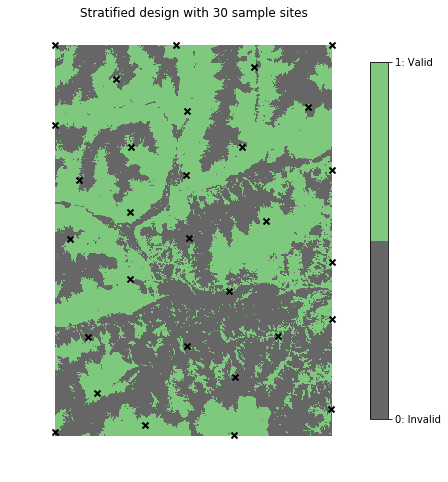

In [111]:
plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap=plt.cm.get_cmap('Accent_r', 2))
plt.title('{} design with {} sample sites'.format('Stratified', len(x)))
plt.axis('off')
cbar = plt.colorbar(fraction=0.04)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0: Invalid', '1: Valid'])
plt.scatter(y_strat, x_strat, c='black', marker='x', linewidth=2)
plt.show()

The Stratified Design Algorithm (SDA) produces a layout where sites are spread evenly spatially, given the constraints of the valid sample areas. 

## Save the output design

In [113]:
def LongLatConvert(x, y, GeoT, auth_code):
    x_proj = x * GeoT[1] + GeoT[0] + (GeoT[1] / 2)
    y_proj = y * GeoT[5] + GeoT[3] + (GeoT[5] / 2)
    p1 = pyproj.Proj(init='EPSG:'+auth_code)
    longlat = p1(x_proj, y_proj, inverse=True)
    return longlat

Add timestamp to output file name so always unique/ no overwriting ###################

In [ ]:
# Convert from row/col to projected
longlat = LongLatConvert(x, y, GeoT, auth_code)

# Reformat and save to csv
result = pd.DataFrame(list(zip(*longlat)), columns = ['longitude','latitude'])
result.index += 1; result['row'] = x; result['col'] = y
result['sampled'] = np.hstack(([1]*nsampled, [0]*(nsp-nsampled)))
result.to_csv('{0}/{1}Site_Stratified_Design.csv'.format(savepath, nsp), index_label='site')